In [12]:
import numpy as np
import tensorflow as tf

import tensorflow.contrib.slim as slim
from tensorflow.python import pywrap_tensorflow

In [13]:
def get_variables_from_checkpoint_file(file_name):
    variables = []
    reader = pywrap_tensorflow.NewCheckpointReader(file_name)

    var_to_shape_map = reader.get_variable_to_shape_map()
    for key in sorted(var_to_shape_map):
        variables.append((key, var_to_shape_map[key]))

    return variables

In [14]:
tf.__version__

'1.12.0'

In [15]:
from os import listdir
from os.path import isfile, join
import ntpath

data_dir_list = ['/home/scpark/ai/datasets/waveglow-datasets/LJSpeech',
                '/home/scpark/ai/datasets/waveglow-datasets/jeon',
                '/home/scpark/ai/datasets/waveglow-datasets/dio']
data_files_list = []

for data_dir in data_dir_list:
    data_files = [join(data_dir, f) for f in listdir(data_dir) if isfile(join(data_dir, f)) and '.npz' in f]
    data_files_list.append(data_files)
    print(len(data_files))
    

13090
10506
1088


In [16]:
BATCH_AXIS = 0
TIME_AXIS = 1
CHANNEL_AXIS = 2


In [17]:
def conv1d(inputs, filters, kernel_size=1, dilation_rate=1, zero_init=False, name='conv1d', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        
        x = inputs[:, None, :, :]
        
        V_initializer = tf.constant_initializer(0.) if zero_init else tf.random_normal_initializer(0, 0.05)
        V = tf.get_variable('V', [1, kernel_size, int(inputs.get_shape()[-1]), filters], tf.float32, 
                            initializer=V_initializer, trainable=True)
        g = tf.get_variable('g', [filters], dtype=tf.float32, initializer=tf.constant_initializer(1.), trainable=True)
        b = tf.get_variable('b', [filters], dtype=tf.float32, initializer=tf.constant_initializer(0.), trainable=True)
        
        # use weight normalization (Salimans & Kingma, 2016)
        W = tf.reshape(g, [1, 1, 1, filters]) * tf.nn.l2_normalize(V, [0, 1, 2])

        # calculate convolutional layer output
        x = tf.nn.bias_add(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID', dilations=[1, 1, dilation_rate, 1]), b)
        x = x[:, 0, :, :]
        
        return x

In [18]:
from tensorflow.contrib.framework.python.ops import add_arg_scope

# Invertible 1x1 conv
@add_arg_scope
def invertible_1x1_conv(name, z, c, reverse=False):

    if True:  # Set to "False" to use the LU-decomposed version

        with tf.variable_scope(name):

            shape = tf.shape(z)
            w_shape = [c, c]

            # Sample a random orthogonal matrix:
            w_init = np.linalg.qr(np.random.randn(
                *w_shape))[0].astype('float32')
            
            print(np.linalg.det(w_init))
            
            if np.linalg.det(w_init) < 0:
                w_init[:, 0] = -1. * w_init[:, 0]

            w = tf.get_variable("W", dtype=tf.float32, initializer=w_init)

            # dlogdet = tf.linalg.LinearOperator(w).log_abs_determinant() * shape[1]*shape[2]
            dlogdet = tf.cast(tf.log(abs(tf.matrix_determinant(
                tf.cast(w, 'float64')))), 'float32') * tf.cast(shape[0] * shape[1] * shape[2], tf.float32)

            if not reverse:

                _w = tf.reshape(w, [1, 1] + w_shape)
                z = tf.nn.conv2d(z, _w, [1, 1, 1, 1],
                                 'SAME', data_format='NHWC')

                return z, dlogdet
            else:

                _w = tf.matrix_inverse(w)
                _w = tf.reshape(_w, [1, 1]+w_shape)
                z = tf.nn.conv2d(z, _w, [1, 1, 1, 1],
                                 'SAME', data_format='NHWC')

                return z, dlogdet

            
def Invertible1x1Conv(z, c, reverse=False, name='inv1x1conv', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        z = z[:, None, :, :]
        z, logdet = invertible_1x1_conv(name, z, c, reverse=reverse)
        z = z[:, 0, :, :]
        
        if reverse:
            return z
        else:
            return z, logdet    

In [19]:
def fused_add_tanh_sigmoid_multiply(inputs, n_channels):
    in_act = inputs[0] + inputs[1] + inputs[2]
    t_act = tf.tanh(in_act[:, :, :n_channels])
    s_act = tf.sigmoid(in_act[:, :, n_channels:])
    acts = t_act * s_act
    
    return acts

In [20]:
def WN(audio, spect, speaker, n_channels, n_layers, kernel_size, name='wavenet', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        n_in_channels = int(audio.get_shape()[-1])
        
        audio = conv1d(audio, n_channels, name='start')
    
        for i in range(n_layers):
            
            with tf.variable_scope(str(i), reuse=tf.AUTO_REUSE):
                
                dilation = 2 ** i
                padding = int((kernel_size * dilation - dilation) / 2)
                audio_padded = tf.pad(audio, [[0, 0], [padding, padding], [0, 0]])
                
                in_acts = conv1d(audio_padded, 2 * n_channels, kernel_size, dilation, name='in_layer')
                cond_acts = conv1d(spect, 2 * n_channels, name='cond_layer')
                speaker_acts = conv1d(speaker, 2 * n_channels, name='speaker_layer')
                acts = fused_add_tanh_sigmoid_multiply([in_acts, cond_acts, speaker_acts], n_channels)
                
                res_skip_channels = 2 * n_channels if i < n_layers - 1 else n_channels
                res_skip_acts = conv1d(acts, res_skip_channels, name='res_skip_layer')
                
                if i < n_layers - 1:
                    audio = res_skip_acts[:, :, :n_channels] + audio
                    skip_acts = res_skip_acts[:, :, n_channels:]
                else:
                    skip_acts = res_skip_acts
                    
                if i == 0:
                    output = skip_acts
                else:
                    output = skip_acts + output

        # Zero Initialization
        output = tf.layers.conv1d(output, filters=2 * n_in_channels,
                                kernel_size=1, 
                                kernel_initializer=tf.zeros_initializer(), 
                                bias_initializer=tf.zeros_initializer(), reuse=reuse)
        output_a, output_b = tf.split(output, num_or_size_splits=2, axis=CHANNEL_AXIS)
        
        return output_a, output_b
                
        

In [21]:
def upsample(spect, n_mel_channels, kernel_size, stride, name='upsample', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
        # spect : [Batch, Time, n_mel_channels]
        
        # expand height
        upsampled_spect = spect[:, None, :, :]
        upsampled_spect = tf.layers.conv2d_transpose(inputs=upsampled_spect, 
                                                     filters=n_mel_channels, 
                                                     kernel_size=(1, kernel_size), 
                                                     strides=(1, stride),
                                                     padding='SAME')
        upsampled_spect = upsampled_spect[:, 0, :, :]
    
    return upsampled_spect

def speakerEmbedding(speaker, speaker_num, length, name='speaker_embedding', reuse=False):
    with tf.variable_scope(name, reuse=reuse):
        embedding_table = tf.get_variable('embedding', [speaker_num, 32], dtype=tf.float32,
                                        initializer=tf.truncated_normal_initializer(stddev=0.5))
        speaker_embedding = tf.nn.embedding_lookup(embedding_table, speaker)
        speaker_embedding = tf.tile(speaker_embedding[:, None, :], [1, length, 1])
        
        return speaker_embedding
    

In [22]:
def waveGlow(audio, spect, speaker, speaker_num, n_mel_channels, n_flows, n_group, n_early_every, n_early_size, 
             WN_n_channels, WN_n_layers, WN_kernel_size,
             name='WaveGlow', reuse=False):
    
    with tf.variable_scope(name, reuse=reuse):
    
        # audio : [Batch, Time]
        # spect : [Batch, Time / 256, n_mel_channels]

        Batch = tf.shape(audio)[0]
        Time = tf.shape(audio)[1]

        # [Batch, Time, n_mel_channels]
        spect = upsample(spect, n_mel_channels, 1024, 256)
#        spect = spect[:, :Time]
        
        # [Batch, Time / n_group, n_mel_channels * n_group]
        spect = tf.reshape(spect, [Batch, -1, n_mel_channels * n_group])
        audio = tf.reshape(audio, [Batch, -1, n_group])        
        speaker = speakerEmbedding(speaker, speaker_num, tf.shape(audio)[1])

        output_audio = []
        log_s_list = []
        log_det_W_list = []

        n_remaining_channels = n_group

        for k in range(n_flows):
            
            with tf.variable_scope('flow_' + str(k), reuse=reuse):
                
                print('flow ', k)
                
                if k % n_early_every == 0 and k > 0:
                    output_audio.append(audio[:, :, :n_early_size])
                    audio = audio[:, :, n_early_size:]
                    n_remaining_channels = n_remaining_channels - n_early_size
                    
                audio, log_det_W = Invertible1x1Conv(audio, n_remaining_channels)
                log_det_W_list.append(log_det_W)

                audio_0, audio_1 = tf.split(audio, 2, axis=CHANNEL_AXIS)

                log_s, b = WN(audio_0, spect, speaker, 
                            n_channels=WN_n_channels, n_layers=WN_n_layers, kernel_size=WN_kernel_size)

                audio_1 = tf.exp(log_s) * audio_1 + b
                log_s_list.append(log_s)

                audio = tf.concat([audio_0, audio_1], axis=CHANNEL_AXIS)

        output_audio.append(audio)

        return tf.concat(output_audio, axis=CHANNEL_AXIS), log_s_list, log_det_W_list, n_remaining_channels
    
def waveGlowInverse(spect, speaker, speaker_num, n_mel_channels, n_flows, n_group, n_early_every, n_early_size, n_remaining_channels,
                    WN_n_channels, WN_n_layers, WN_kernel_size,
                    sigma=1.0, name='WaveGlow', reuse=True):
    
    with tf.variable_scope(name, reuse=reuse):
        
        # spect : [Batch, Time / 256, n_mel_channels]
        
        spect = upsample(spect, n_mel_channels, 1024, 256, reuse=reuse)
        Batch = tf.shape(spect)[0]
        
        spect = tf.reshape(spect, [Batch, -1, n_mel_channels * n_group])
        Time = tf.shape(spect)[1]

        audio = tf.random_normal(shape=[Batch, Time, n_remaining_channels], stddev=sigma, dtype=tf.float32)
        speaker = speakerEmbedding(speaker, speaker_num, Time, reuse=reuse)
        
        for k in reversed(range(n_flows)):
            
            with tf.variable_scope('flow_' + str(k), reuse=reuse):
                
                print('inverse flow ', k)
                
                audio_0, audio_1 = tf.split(audio, 2, axis=CHANNEL_AXIS)
                log_s, b = WN(audio_0, spect, speaker, 
                            n_channels=WN_n_channels, n_layers=WN_n_layers, kernel_size=WN_kernel_size)
                audio_1 = (audio_1 - b) / tf.exp(log_s)
                audio = tf.concat([audio_0, audio_1], axis=CHANNEL_AXIS)
                
                audio = Invertible1x1Conv(audio, n_remaining_channels, reverse=True)
                
                if k % n_early_every == 0 and k > 0:
                    z = tf.random_normal(shape=[Batch, Time, n_early_size], dtype=tf.float32)
                    audio = tf.concat([sigma * z, audio], axis=CHANNEL_AXIS)
                    n_remaining_channels = n_remaining_channels + n_early_size
        
        audio = tf.reshape(audio, [Batch, -1])
        
        return audio
    
def waveGlowLoss(z, log_s_list, log_det_W_list, sigma=1.0):
    
    log_s_total = 0
    log_det_W_total = 0
    
    for i, log_s in enumerate(log_s_list):
        log_s_total += tf.reduce_sum(log_s)
        log_det_W_total += log_det_W_list[i]
        
    nll_loss = tf.reduce_sum(z * z) / (2. * sigma * sigma) 
    det_loss = -log_s_total - log_det_W_total
    norm_factor = tf.cast(tf.shape(z)[0] * tf.shape(z)[1] * tf.shape(z)[2], tf.float32)
    loss = (nll_loss + det_loss) / norm_factor
    
    return loss


            

In [23]:
tf.reset_default_graph()
Batch = None
Time = None
n_speakers = 3
n_mel_channels = 80
n_flows = 12
n_group = 8
n_early_every = 4
n_early_size = 2

WN_n_layers = 8
WN_n_channels = 512
WN_kernel_size = 3

audio = tf.placeholder(dtype=tf.float32, shape=[Batch, None])
spect = tf.placeholder(dtype=tf.float32, shape=[Batch, None, n_mel_channels])
### Global Speaker IDs
speaker = tf.placeholder(dtype=tf.int32, shape=[None])


z, log_s_list, log_det_W_list, n_remaining_channels = \
                    waveGlow(audio, spect, speaker, n_speakers, 
                             n_mel_channels, n_flows, n_group, n_early_every, n_early_size,
                             WN_n_channels, WN_n_layers, WN_kernel_size)

audio_sample = waveGlowInverse(spect, speaker, n_speakers, 
                               n_mel_channels, n_flows, n_group, n_early_every, n_early_size, n_remaining_channels,
                               WN_n_channels, WN_n_layers, WN_kernel_size, reuse=True)

loss = waveGlowLoss(z, log_s_list, log_det_W_list, sigma=1.0)
print(loss)

global_step = tf.Variable(0, 'global_step')
optim = tf.train.AdamOptimizer(1e-4).minimize(loss, global_step)

''' Log '''

loss_hist = tf.summary.scalar('loss', loss)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())



writer = tf.summary.FileWriter('save/waveglow_LJ', sess.graph)

print('done')


flow  0
-1.0
flow  1
-1.0
flow  2
-1.0
flow  3
-0.99999994
flow  4
-1.0
flow  5
-0.99999994
flow  6
-1.0
flow  7
-1.0
flow  8
-1.0
flow  9
-1.0
flow  10
-1.0
flow  11
-1.0
inverse flow  11
-1.0
inverse flow  10
-1.0000001
inverse flow  9
-1.0
inverse flow  8
-1.0
inverse flow  7
-0.99999994
inverse flow  6
-1.0
inverse flow  5
-1.0
inverse flow  4
-1.0
inverse flow  3
-1.0
inverse flow  2
-1.0
inverse flow  1
-1.0
inverse flow  0
-1.0
Tensor("truediv_1:0", shape=(), dtype=float32)
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'global_step' has type str, but expected one of: int, long, bool
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'global_step' has type str, but expected one of: int, long, bool
done


In [26]:
load_dir = 'save/waveglow_LJ'
save_dir = 'save/waveglow_LJ'

if True:
    #Restore variables from disk.
    restore_path = tf.train.latest_checkpoint(load_dir)
    saved_variables = get_variables_from_checkpoint_file(restore_path)
    model_variables = slim.get_variables_to_restore()
    restore_variables = []

    for model_variable in model_variables:
        loaded = False
        for saved_variable_name, saved_variable_shape in saved_variables:
            model_variable_name = model_variable.name.split(":")[0]
            if saved_variable_name == model_variable_name and tuple(saved_variable_shape) == model_variable.shape:
                restore_variables.append(model_variable)
                print('load success : ', model_variable_name)
                loaded = True
                break
        if not loaded:
            print('load failed : ', model_variable_name)

    init_saver = tf.train.Saver(restore_variables)
    init_saver.restore(sess, restore_path)

saver = tf.train.Saver()      
print('done')


load success :  WaveGlow/upsample/conv2d_transpose/kernel
load success :  WaveGlow/upsample/conv2d_transpose/bias
load failed :  WaveGlow/speaker_embedding/embedding
load success :  WaveGlow/flow_0/inv1x1conv/inv1x1conv/W
load success :  WaveGlow/flow_0/wavenet/start/V
load success :  WaveGlow/flow_0/wavenet/start/g
load success :  WaveGlow/flow_0/wavenet/start/b
load success :  WaveGlow/flow_0/wavenet/0/in_layer/V
load success :  WaveGlow/flow_0/wavenet/0/in_layer/g
load success :  WaveGlow/flow_0/wavenet/0/in_layer/b
load success :  WaveGlow/flow_0/wavenet/0/cond_layer/V
load success :  WaveGlow/flow_0/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_0/wavenet/0/cond_layer/b
load failed :  WaveGlow/flow_0/wavenet/0/speaker_layer/V
load failed :  WaveGlow/flow_0/wavenet/0/speaker_layer/g
load failed :  WaveGlow/flow_0/wavenet/0/speaker_layer/b
load success :  WaveGlow/flow_0/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_0/wavenet/0/res_skip_layer/g
load success :  WaveG

load failed :  WaveGlow/flow_2/wavenet/0/speaker_layer/b
load success :  WaveGlow/flow_2/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_2/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_2/wavenet/0/res_skip_layer/b
load success :  WaveGlow/flow_2/wavenet/1/in_layer/V
load success :  WaveGlow/flow_2/wavenet/1/in_layer/g
load success :  WaveGlow/flow_2/wavenet/1/in_layer/b
load success :  WaveGlow/flow_2/wavenet/1/cond_layer/V
load success :  WaveGlow/flow_2/wavenet/1/cond_layer/g
load success :  WaveGlow/flow_2/wavenet/1/cond_layer/b
load failed :  WaveGlow/flow_2/wavenet/1/speaker_layer/V
load failed :  WaveGlow/flow_2/wavenet/1/speaker_layer/g
load failed :  WaveGlow/flow_2/wavenet/1/speaker_layer/b
load success :  WaveGlow/flow_2/wavenet/1/res_skip_layer/V
load success :  WaveGlow/flow_2/wavenet/1/res_skip_layer/g
load success :  WaveGlow/flow_2/wavenet/1/res_skip_layer/b
load success :  WaveGlow/flow_2/wavenet/2/in_layer/V
load success :  WaveGlow/flow_2/wavenet/2

load failed :  WaveGlow/flow_3/wavenet/4/speaker_layer/V
load failed :  WaveGlow/flow_3/wavenet/4/speaker_layer/g
load failed :  WaveGlow/flow_3/wavenet/4/speaker_layer/b
load success :  WaveGlow/flow_3/wavenet/4/res_skip_layer/V
load success :  WaveGlow/flow_3/wavenet/4/res_skip_layer/g
load success :  WaveGlow/flow_3/wavenet/4/res_skip_layer/b
load success :  WaveGlow/flow_3/wavenet/5/in_layer/V
load success :  WaveGlow/flow_3/wavenet/5/in_layer/g
load success :  WaveGlow/flow_3/wavenet/5/in_layer/b
load success :  WaveGlow/flow_3/wavenet/5/cond_layer/V
load success :  WaveGlow/flow_3/wavenet/5/cond_layer/g
load success :  WaveGlow/flow_3/wavenet/5/cond_layer/b
load failed :  WaveGlow/flow_3/wavenet/5/speaker_layer/V
load failed :  WaveGlow/flow_3/wavenet/5/speaker_layer/g
load failed :  WaveGlow/flow_3/wavenet/5/speaker_layer/b
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/V
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/g
load success :  WaveGlow/flow_3/wavenet

load success :  WaveGlow/flow_5/wavenet/0/in_layer/V
load success :  WaveGlow/flow_5/wavenet/0/in_layer/g
load success :  WaveGlow/flow_5/wavenet/0/in_layer/b
load success :  WaveGlow/flow_5/wavenet/0/cond_layer/V
load success :  WaveGlow/flow_5/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_5/wavenet/0/cond_layer/b
load failed :  WaveGlow/flow_5/wavenet/0/speaker_layer/V
load failed :  WaveGlow/flow_5/wavenet/0/speaker_layer/g
load failed :  WaveGlow/flow_5/wavenet/0/speaker_layer/b
load success :  WaveGlow/flow_5/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_5/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_5/wavenet/0/res_skip_layer/b
load success :  WaveGlow/flow_5/wavenet/1/in_layer/V
load success :  WaveGlow/flow_5/wavenet/1/in_layer/g
load success :  WaveGlow/flow_5/wavenet/1/in_layer/b
load success :  WaveGlow/flow_5/wavenet/1/cond_layer/V
load success :  WaveGlow/flow_5/wavenet/1/cond_layer/g
load success :  WaveGlow/flow_5/wavenet/1/cond_layer/b
load

load success :  WaveGlow/flow_7/wavenet/2/cond_layer/g
load success :  WaveGlow/flow_7/wavenet/2/cond_layer/b
load failed :  WaveGlow/flow_7/wavenet/2/speaker_layer/V
load failed :  WaveGlow/flow_7/wavenet/2/speaker_layer/g
load failed :  WaveGlow/flow_7/wavenet/2/speaker_layer/b
load success :  WaveGlow/flow_7/wavenet/2/res_skip_layer/V
load success :  WaveGlow/flow_7/wavenet/2/res_skip_layer/g
load success :  WaveGlow/flow_7/wavenet/2/res_skip_layer/b
load success :  WaveGlow/flow_7/wavenet/3/in_layer/V
load success :  WaveGlow/flow_7/wavenet/3/in_layer/g
load success :  WaveGlow/flow_7/wavenet/3/in_layer/b
load success :  WaveGlow/flow_7/wavenet/3/cond_layer/V
load success :  WaveGlow/flow_7/wavenet/3/cond_layer/g
load success :  WaveGlow/flow_7/wavenet/3/cond_layer/b
load failed :  WaveGlow/flow_7/wavenet/3/speaker_layer/V
load failed :  WaveGlow/flow_7/wavenet/3/speaker_layer/g
load failed :  WaveGlow/flow_7/wavenet/3/speaker_layer/b
load success :  WaveGlow/flow_7/wavenet/3/res_s

load success :  WaveGlow/flow_9/wavenet/0/res_skip_layer/V
load success :  WaveGlow/flow_9/wavenet/0/res_skip_layer/g
load success :  WaveGlow/flow_9/wavenet/0/res_skip_layer/b
load success :  WaveGlow/flow_9/wavenet/1/in_layer/V
load success :  WaveGlow/flow_9/wavenet/1/in_layer/g
load success :  WaveGlow/flow_9/wavenet/1/in_layer/b
load success :  WaveGlow/flow_9/wavenet/1/cond_layer/V
load success :  WaveGlow/flow_9/wavenet/1/cond_layer/g
load success :  WaveGlow/flow_9/wavenet/1/cond_layer/b
load failed :  WaveGlow/flow_9/wavenet/1/speaker_layer/V
load failed :  WaveGlow/flow_9/wavenet/1/speaker_layer/g
load failed :  WaveGlow/flow_9/wavenet/1/speaker_layer/b
load success :  WaveGlow/flow_9/wavenet/1/res_skip_layer/V
load success :  WaveGlow/flow_9/wavenet/1/res_skip_layer/g
load success :  WaveGlow/flow_9/wavenet/1/res_skip_layer/b
load success :  WaveGlow/flow_9/wavenet/2/in_layer/V
load success :  WaveGlow/flow_9/wavenet/2/in_layer/g
load success :  WaveGlow/flow_9/wavenet/2/in_

load failed :  WaveGlow/flow_10/wavenet/7/speaker_layer/V
load failed :  WaveGlow/flow_10/wavenet/7/speaker_layer/g
load failed :  WaveGlow/flow_10/wavenet/7/speaker_layer/b
load success :  WaveGlow/flow_10/wavenet/7/res_skip_layer/V
load success :  WaveGlow/flow_10/wavenet/7/res_skip_layer/g
load success :  WaveGlow/flow_10/wavenet/7/res_skip_layer/b
load success :  WaveGlow/flow_10/wavenet/conv1d/kernel
load success :  WaveGlow/flow_10/wavenet/conv1d/bias
load success :  WaveGlow/flow_11/inv1x1conv/inv1x1conv/W
load success :  WaveGlow/flow_11/wavenet/start/V
load success :  WaveGlow/flow_11/wavenet/start/g
load success :  WaveGlow/flow_11/wavenet/start/b
load success :  WaveGlow/flow_11/wavenet/0/in_layer/V
load success :  WaveGlow/flow_11/wavenet/0/in_layer/g
load success :  WaveGlow/flow_11/wavenet/0/in_layer/b
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/V
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/g
load success :  WaveGlow/flow_11/wavenet/0/cond_layer/b
load

load success :  WaveGlow/flow_0/wavenet/0/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_0/wavenet/0/res_skip_layer/b/Adam
load success :  WaveGlow/flow_0/wavenet/0/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_0/wavenet/1/in_layer/V/Adam
load success :  WaveGlow/flow_0/wavenet/1/in_layer/V/Adam_1
load success :  WaveGlow/flow_0/wavenet/1/in_layer/g/Adam
load success :  WaveGlow/flow_0/wavenet/1/in_layer/g/Adam_1
load success :  WaveGlow/flow_0/wavenet/1/in_layer/b/Adam
load success :  WaveGlow/flow_0/wavenet/1/in_layer/b/Adam_1
load success :  WaveGlow/flow_0/wavenet/1/cond_layer/V/Adam
load success :  WaveGlow/flow_0/wavenet/1/cond_layer/V/Adam_1
load success :  WaveGlow/flow_0/wavenet/1/cond_layer/g/Adam
load success :  WaveGlow/flow_0/wavenet/1/cond_layer/g/Adam_1
load success :  WaveGlow/flow_0/wavenet/1/cond_layer/b/Adam
load success :  WaveGlow/flow_0/wavenet/1/cond_layer/b/Adam_1
load failed :  WaveGlow/flow_0/wavenet/1/speaker_layer/V/Adam
load failed :  WaveGlo

load success :  WaveGlow/flow_0/wavenet/6/res_skip_layer/V/Adam_1
load success :  WaveGlow/flow_0/wavenet/6/res_skip_layer/g/Adam
load success :  WaveGlow/flow_0/wavenet/6/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_0/wavenet/6/res_skip_layer/b/Adam
load success :  WaveGlow/flow_0/wavenet/6/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_0/wavenet/7/in_layer/V/Adam
load success :  WaveGlow/flow_0/wavenet/7/in_layer/V/Adam_1
load success :  WaveGlow/flow_0/wavenet/7/in_layer/g/Adam
load success :  WaveGlow/flow_0/wavenet/7/in_layer/g/Adam_1
load success :  WaveGlow/flow_0/wavenet/7/in_layer/b/Adam
load success :  WaveGlow/flow_0/wavenet/7/in_layer/b/Adam_1
load success :  WaveGlow/flow_0/wavenet/7/cond_layer/V/Adam
load success :  WaveGlow/flow_0/wavenet/7/cond_layer/V/Adam_1
load success :  WaveGlow/flow_0/wavenet/7/cond_layer/g/Adam
load success :  WaveGlow/flow_0/wavenet/7/cond_layer/g/Adam_1
load success :  WaveGlow/flow_0/wavenet/7/cond_layer/b/Adam
load success :  

load failed :  WaveGlow/flow_3/wavenet/5/speaker_layer/b/Adam
load failed :  WaveGlow/flow_3/wavenet/5/speaker_layer/b/Adam_1
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/V/Adam
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/V/Adam_1
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/g/Adam
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/b/Adam
load success :  WaveGlow/flow_3/wavenet/5/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_3/wavenet/6/in_layer/V/Adam
load success :  WaveGlow/flow_3/wavenet/6/in_layer/V/Adam_1
load success :  WaveGlow/flow_3/wavenet/6/in_layer/g/Adam
load success :  WaveGlow/flow_3/wavenet/6/in_layer/g/Adam_1
load success :  WaveGlow/flow_3/wavenet/6/in_layer/b/Adam
load success :  WaveGlow/flow_3/wavenet/6/in_layer/b/Adam_1
load success :  WaveGlow/flow_3/wavenet/6/cond_layer/V/Adam
load success :  WaveGlow/flow_3/wavenet/6/cond_layer/V/Adam_1
load suc

load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/V/Adam
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/V/Adam_1
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/g/Adam
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/b/Adam
load success :  WaveGlow/flow_4/wavenet/5/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_4/wavenet/6/in_layer/V/Adam
load success :  WaveGlow/flow_4/wavenet/6/in_layer/V/Adam_1
load success :  WaveGlow/flow_4/wavenet/6/in_layer/g/Adam
load success :  WaveGlow/flow_4/wavenet/6/in_layer/g/Adam_1
load success :  WaveGlow/flow_4/wavenet/6/in_layer/b/Adam
load success :  WaveGlow/flow_4/wavenet/6/in_layer/b/Adam_1
load success :  WaveGlow/flow_4/wavenet/6/cond_layer/V/Adam
load success :  WaveGlow/flow_4/wavenet/6/cond_layer/V/Adam_1
load success :  WaveGlow/flow_4/wavenet/6/cond_layer/g/Adam
load success :  WaveGlow/flow_4/wavenet/6/cond_layer/g/Adam_1
load success

load success :  WaveGlow/flow_6/wavenet/1/res_skip_layer/b/Adam
load success :  WaveGlow/flow_6/wavenet/1/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_6/wavenet/2/in_layer/V/Adam
load success :  WaveGlow/flow_6/wavenet/2/in_layer/V/Adam_1
load success :  WaveGlow/flow_6/wavenet/2/in_layer/g/Adam
load success :  WaveGlow/flow_6/wavenet/2/in_layer/g/Adam_1
load success :  WaveGlow/flow_6/wavenet/2/in_layer/b/Adam
load success :  WaveGlow/flow_6/wavenet/2/in_layer/b/Adam_1
load success :  WaveGlow/flow_6/wavenet/2/cond_layer/V/Adam
load success :  WaveGlow/flow_6/wavenet/2/cond_layer/V/Adam_1
load success :  WaveGlow/flow_6/wavenet/2/cond_layer/g/Adam
load success :  WaveGlow/flow_6/wavenet/2/cond_layer/g/Adam_1
load success :  WaveGlow/flow_6/wavenet/2/cond_layer/b/Adam
load success :  WaveGlow/flow_6/wavenet/2/cond_layer/b/Adam_1
load failed :  WaveGlow/flow_6/wavenet/2/speaker_layer/V/Adam
load failed :  WaveGlow/flow_6/wavenet/2/speaker_layer/V/Adam_1
load failed :  WaveGlow/

load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/g/Adam
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/b/Adam
load success :  WaveGlow/flow_7/wavenet/3/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_7/wavenet/4/in_layer/V/Adam
load success :  WaveGlow/flow_7/wavenet/4/in_layer/V/Adam_1
load success :  WaveGlow/flow_7/wavenet/4/in_layer/g/Adam
load success :  WaveGlow/flow_7/wavenet/4/in_layer/g/Adam_1
load success :  WaveGlow/flow_7/wavenet/4/in_layer/b/Adam
load success :  WaveGlow/flow_7/wavenet/4/in_layer/b/Adam_1
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/V/Adam
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/V/Adam_1
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/g/Adam
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/g/Adam_1
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/b/Adam
load success :  WaveGlow/flow_7/wavenet/4/cond_layer/b/Adam_1
load failed :  WaveG

load failed :  WaveGlow/flow_8/wavenet/5/speaker_layer/g/Adam_1
load failed :  WaveGlow/flow_8/wavenet/5/speaker_layer/b/Adam
load failed :  WaveGlow/flow_8/wavenet/5/speaker_layer/b/Adam_1
load success :  WaveGlow/flow_8/wavenet/5/res_skip_layer/V/Adam
load success :  WaveGlow/flow_8/wavenet/5/res_skip_layer/V/Adam_1
load success :  WaveGlow/flow_8/wavenet/5/res_skip_layer/g/Adam
load success :  WaveGlow/flow_8/wavenet/5/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_8/wavenet/5/res_skip_layer/b/Adam
load success :  WaveGlow/flow_8/wavenet/5/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_8/wavenet/6/in_layer/V/Adam
load success :  WaveGlow/flow_8/wavenet/6/in_layer/V/Adam_1
load success :  WaveGlow/flow_8/wavenet/6/in_layer/g/Adam
load success :  WaveGlow/flow_8/wavenet/6/in_layer/g/Adam_1
load success :  WaveGlow/flow_8/wavenet/6/in_layer/b/Adam
load success :  WaveGlow/flow_8/wavenet/6/in_layer/b/Adam_1
load success :  WaveGlow/flow_8/wavenet/6/cond_layer/V/Adam
load s

load failed :  WaveGlow/flow_9/wavenet/7/speaker_layer/g/Adam_1
load failed :  WaveGlow/flow_9/wavenet/7/speaker_layer/b/Adam
load failed :  WaveGlow/flow_9/wavenet/7/speaker_layer/b/Adam_1
load success :  WaveGlow/flow_9/wavenet/7/res_skip_layer/V/Adam
load success :  WaveGlow/flow_9/wavenet/7/res_skip_layer/V/Adam_1
load success :  WaveGlow/flow_9/wavenet/7/res_skip_layer/g/Adam
load success :  WaveGlow/flow_9/wavenet/7/res_skip_layer/g/Adam_1
load success :  WaveGlow/flow_9/wavenet/7/res_skip_layer/b/Adam
load success :  WaveGlow/flow_9/wavenet/7/res_skip_layer/b/Adam_1
load success :  WaveGlow/flow_9/wavenet/conv1d/kernel/Adam
load success :  WaveGlow/flow_9/wavenet/conv1d/kernel/Adam_1
load success :  WaveGlow/flow_9/wavenet/conv1d/bias/Adam
load success :  WaveGlow/flow_9/wavenet/conv1d/bias/Adam_1
load success :  WaveGlow/flow_10/inv1x1conv/inv1x1conv/W/Adam
load success :  WaveGlow/flow_10/inv1x1conv/inv1x1conv/W/Adam_1
load success :  WaveGlow/flow_10/wavenet/start/V/Adam
load

load success :  WaveGlow/flow_11/wavenet/1/in_layer/V/Adam_1
load success :  WaveGlow/flow_11/wavenet/1/in_layer/g/Adam
load success :  WaveGlow/flow_11/wavenet/1/in_layer/g/Adam_1
load success :  WaveGlow/flow_11/wavenet/1/in_layer/b/Adam
load success :  WaveGlow/flow_11/wavenet/1/in_layer/b/Adam_1
load success :  WaveGlow/flow_11/wavenet/1/cond_layer/V/Adam
load success :  WaveGlow/flow_11/wavenet/1/cond_layer/V/Adam_1
load success :  WaveGlow/flow_11/wavenet/1/cond_layer/g/Adam
load success :  WaveGlow/flow_11/wavenet/1/cond_layer/g/Adam_1
load success :  WaveGlow/flow_11/wavenet/1/cond_layer/b/Adam
load success :  WaveGlow/flow_11/wavenet/1/cond_layer/b/Adam_1
load failed :  WaveGlow/flow_11/wavenet/1/speaker_layer/V/Adam
load failed :  WaveGlow/flow_11/wavenet/1/speaker_layer/V/Adam_1
load failed :  WaveGlow/flow_11/wavenet/1/speaker_layer/g/Adam
load failed :  WaveGlow/flow_11/wavenet/1/speaker_layer/g/Adam_1
load failed :  WaveGlow/flow_11/wavenet/1/speaker_layer/b/Adam
load fai

INFO:tensorflow:Restoring parameters from save/waveglow_LJ/waveglow_142000.ckpt
done


In [27]:
def get_test_data(speaker, time_length, index):
    waves = []
    specs = []
    
    data_files = data_files_list[speaker]
    data_file = data_files[index]
    data = np.load(data_file)
    wave, spec = data['wave'], data['mel']

    start = 0
    end = time_length
    waves = wave[start * 256 : end * 256]
    specs = spec[start:end]
    
    return speaker, waves, specs
    

def get_data(time_length):
    waves = []
    specs = []
    
    read_speaker = np.random.randint(0, len(data_files_list), 1)[0]
    length = 0
    data_files = data_files_list[read_speaker]
    
    while(True):
        read_index = np.random.randint(0, len(data_files), 1)[0]
        data_file = data_files[read_index]
        data = np.load(data_file)
        wave, spec = data['wave'], data['mel']

        if len(spec) == 0 or len(wave) == 0:
            continue
            
        length += spec.shape[0]

        waves.append(wave)
        specs.append(spec)
        
        if length > time_length:
            break

    waves = np.concatenate(waves, axis=0)
    specs = np.concatenate(specs, axis=0)

    length = np.maximum(len(specs), time_length)
    if length > time_length:
        start = np.random.randint(length - time_length, size=1)[0]
    else:
        start = 0

    end = start + time_length
    waves = waves[start * 256 : end * 256]
    specs = specs[start:end]
    
    return read_speaker, waves, specs


In [ ]:
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

time_length = 120

while(True):
    for i in range(500):
        _speaker, _waves, _specs = get_data(time_length)
        
        fetches = [optim, global_step, loss, loss_hist]
        feed_dicts = {audio: np.expand_dims(_waves, axis=0),
                      spect: np.expand_dims(_specs, axis=0),
                      speaker: np.expand_dims(np.array(_speaker), axis=0)}
        _, _global_step, _loss, _loss_hist = sess.run(fetches, feed_dict=feed_dicts)
        
        if _global_step % 10 == 0:
                writer.add_summary(_loss_hist, _global_step)
                
        if _global_step % 1000 == 0:
            save_path = saver.save(sess, save_dir + '/waveglow_' + str(_global_step) + '.ckpt')
            print("Model saved in path: %s" % save_path)
        
        print(_global_step, _loss)
        
    _speaker, _waves, _specs = get_test_data(2, 100, 0)
        
    feed_dicts = {audio: np.expand_dims(_waves, axis=0),
                  spect: np.expand_dims(_specs, axis=0),
                  speaker: np.expand_dims(np.array(_speaker), axis=0)}
    
    _audio_sample = sess.run(audio_sample, feed_dict=feed_dicts)
    _audio_sample = np.clip(_audio_sample, -1., 1.)
    clear_output()
    
    plt.figure(figsize=[18, 3])
    plt.plot(_waves, alpha=0.5)
    plt.plot(_audio_sample[0], alpha=0.5)
    plt.show()    
    

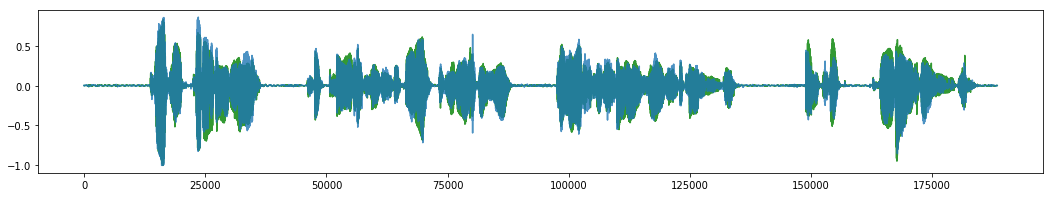

In [191]:
_speaker, _waves, _specs = get_test_data(1, 1000, 80)        

_audio_samples = []
for start_index in range(0, len(_specs), 100):
    feed_dicts = {spect: np.expand_dims(_specs[start_index:start_index+100], axis=0),
                  speaker: np.expand_dims(np.array(_speaker), axis=0)}
    _audio_sample = sess.run(audio_sample, feed_dict=feed_dicts)
    _audio_sample = np.clip(_audio_sample, -1., 1.)
    _audio_samples.append(_audio_sample)

_audio_samples = np.concatenate(_audio_samples, axis=-1)

plt.figure(figsize=[18, 3])
plt.plot(_waves, alpha=0.8, color='g')
plt.plot(_audio_samples[0], alpha=0.8)
plt.show()

In [192]:
import IPython.display as ipd
ipd.Audio(_audio_samples[0], rate=22050)


In [193]:
import IPython.display as ipd
ipd.Audio(_waves, rate=22050)
